##### [sample solution, trained for a few hours (not converged)]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="alien"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 5

In [3]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

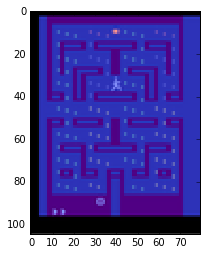

In [4]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
import lasagne

Using gpu device 2: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)


In [6]:
from lasagne.layers import InputLayer, DimshuffleLayer

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))




In [7]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(observation_reshape,16,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),32,filter_size=(4,4),stride=(2,2),name='conv1')

conv2 = Conv2DLayer(batch_norm(conv1),64,filter_size=(4,4),stride=(2,2),name='conv2')

dense0 = DenseLayer(batch_norm(conv2),256,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [8]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [9]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)


In [10]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 conv2.W,
 conv2_bn.beta,
 conv2_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [11]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE,max_size=10000)


In [12]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log][:2])
print(reward_log[:2])

[['DOWNFIRE' 'DOWNFIRE' 'DOWNLEFT' 'DOWNFIRE' 'DOWNFIRE' 'DOWNFIRE'
  'DOWNLEFT']
 ['DOWNFIRE' 'DOWNFIRE' 'DOWNLEFT' 'DOWNFIRE' 'DOWNFIRE' 'DOWNFIRE'
  'DOWNLEFT']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 316 ms, sys: 16 ms, total: 332 ms
Wall time: 332 ms


In [13]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [14]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [15]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [16]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [17]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [19]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-19 00:09:50,908] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 00:09:50,908] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-10-19 00:09:59,165] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1205 timesteps with reward=150.0


In [20]:
from IPython.display import HTML

video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [21]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

iter=10	epsilon=0.496	reward/step=0.27273
iter=20	epsilon=0.491	reward/step=0.31429
iter=30	epsilon=0.487	reward/step=0.26452
iter=40	epsilon=0.482	reward/step=0.24390
iter=50	epsilon=0.478	reward/step=0.24706
iter=60	epsilon=0.474	reward/step=0.23607
iter=70	epsilon=0.470	reward/step=0.21408
iter=80	epsilon=0.465	reward/step=0.20741
iter=90	epsilon=0.461	reward/step=0.19121


[2016-10-19 00:14:49,458] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 00:14:49,458] Clearing 4 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.457	reward/step=0.18218


[2016-10-19 00:14:56,379] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1022 timesteps with reward=140.0


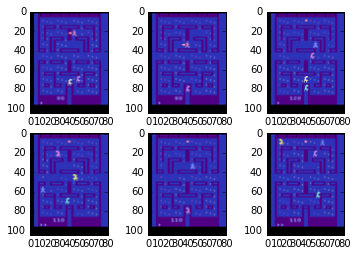

iter=110	epsilon=0.453	reward/step=0.17477
iter=120	epsilon=0.449	reward/step=0.17521
iter=130	epsilon=0.445	reward/step=0.17099
iter=140	epsilon=0.441	reward/step=0.16454
iter=150	epsilon=0.437	reward/step=0.16159
iter=160	epsilon=0.433	reward/step=0.15280
iter=170	epsilon=0.430	reward/step=0.14737
iter=180	epsilon=0.426	reward/step=0.15028
iter=190	epsilon=0.422	reward/step=0.14555
!


[2016-10-19 00:21:25,115] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 00:21:25,115] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.418	reward/step=0.14328


[2016-10-19 00:21:33,986] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1344 timesteps with reward=150.0


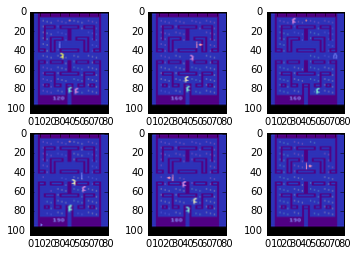

!
iter=210	epsilon=0.415	reward/step=0.14597
!
!
iter=220	epsilon=0.411	reward/step=0.14389
iter=230	epsilon=0.408	reward/step=0.14805
!
!
iter=240	epsilon=0.404	reward/step=0.15187
iter=250	epsilon=0.400	reward/step=0.15378
!
!
iter=260	epsilon=0.397	reward/step=0.15326
!
iter=270	epsilon=0.394	reward/step=0.15277
iter=280	epsilon=0.390	reward/step=0.15231
!
iter=290	epsilon=0.387	reward/step=0.15052


[2016-10-19 00:30:14,795] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 00:30:14,796] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.383	reward/step=0.15150


[2016-10-19 00:30:24,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1508 timesteps with reward=240.0


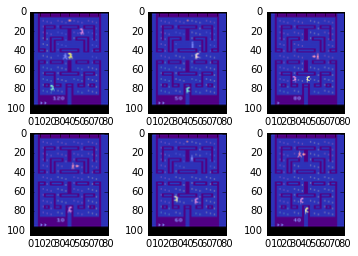

iter=310	epsilon=0.380	reward/step=0.15691
iter=320	epsilon=0.377	reward/step=0.15576
iter=330	epsilon=0.374	reward/step=0.15227
iter=340	epsilon=0.370	reward/step=0.15425
iter=350	epsilon=0.367	reward/step=0.15271
iter=360	epsilon=0.364	reward/step=0.15180
iter=370	epsilon=0.361	reward/step=0.15040
iter=380	epsilon=0.358	reward/step=0.15013
!
iter=390	epsilon=0.355	reward/step=0.14885


[2016-10-19 00:41:30,153] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 00:41:30,154] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.352	reward/step=0.14713


[2016-10-19 00:41:37,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1147 timesteps with reward=210.0


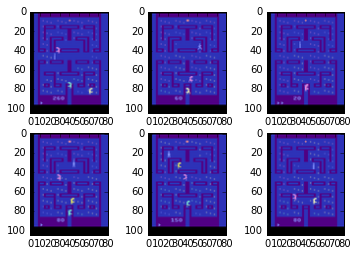

iter=410	epsilon=0.349	reward/step=0.14745
iter=420	epsilon=0.346	reward/step=0.14632
iter=430	epsilon=0.343	reward/step=0.14432
iter=440	epsilon=0.340	reward/step=0.14331
!
iter=450	epsilon=0.337	reward/step=0.14457
iter=460	epsilon=0.334	reward/step=0.14403
!
iter=470	epsilon=0.331	reward/step=0.14352
!
iter=480	epsilon=0.328	reward/step=0.14428
iter=490	epsilon=0.326	reward/step=0.14379
!


[2016-10-19 00:54:40,473] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 00:54:40,474] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.323	reward/step=0.14531


[2016-10-19 00:54:52,686] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1914 timesteps with reward=230.0


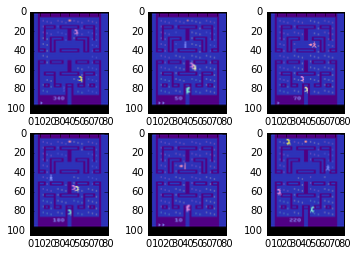

iter=510	epsilon=0.320	reward/step=0.14716
iter=520	epsilon=0.318	reward/step=0.14702
iter=530	epsilon=0.315	reward/step=0.14689
iter=540	epsilon=0.312	reward/step=0.14566
!
!
iter=550	epsilon=0.310	reward/step=0.14592
!
!
iter=560	epsilon=0.307	reward/step=0.14652
iter=570	epsilon=0.304	reward/step=0.14781
iter=580	epsilon=0.302	reward/step=0.14905
!
iter=590	epsilon=0.299	reward/step=0.14958


[2016-10-19 01:09:49,958] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 01:09:49,959] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.297	reward/step=0.14975


[2016-10-19 01:09:57,245] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1099 timesteps with reward=130.0


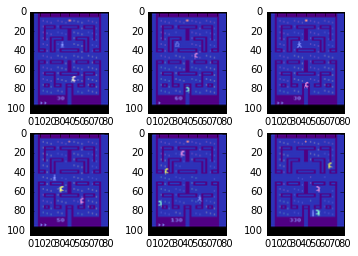

!
iter=610	epsilon=0.295	reward/step=0.14894
iter=620	epsilon=0.292	reward/step=0.14879
iter=630	epsilon=0.290	reward/step=0.14929
iter=640	epsilon=0.287	reward/step=0.15008
iter=650	epsilon=0.285	reward/step=0.15207
iter=660	epsilon=0.283	reward/step=0.16823
iter=670	epsilon=0.280	reward/step=0.16721
iter=680	epsilon=0.278	reward/step=0.16593
!
iter=690	epsilon=0.276	reward/step=0.16527


[2016-10-19 01:27:08,134] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 01:27:08,135] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.273	reward/step=0.16605


[2016-10-19 01:27:15,158] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1050 timesteps with reward=180.0


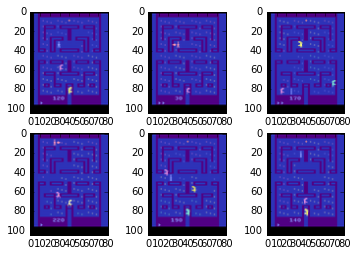

!
iter=710	epsilon=0.271	reward/step=0.16681
iter=720	epsilon=0.269	reward/step=0.16838
iter=730	epsilon=0.267	reward/step=0.17127
iter=740	epsilon=0.265	reward/step=0.17139
iter=750	epsilon=0.263	reward/step=0.17017
!
iter=760	epsilon=0.260	reward/step=0.16925
iter=770	epsilon=0.258	reward/step=0.17017
iter=780	epsilon=0.256	reward/step=0.16978
iter=790	epsilon=0.254	reward/step=0.16915


[2016-10-19 01:47:31,054] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 01:47:31,054] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.252	reward/step=0.16904


[2016-10-19 01:47:38,105] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1050 timesteps with reward=120.0


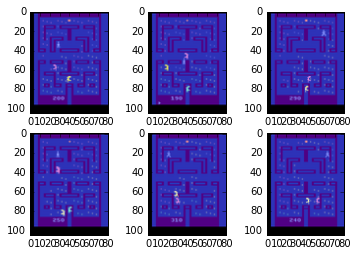

iter=810	epsilon=0.250	reward/step=0.16843
iter=820	epsilon=0.248	reward/step=0.16711
!
!
iter=830	epsilon=0.246	reward/step=0.16631
!
iter=840	epsilon=0.244	reward/step=0.16742
!
!
!
iter=850	epsilon=0.242	reward/step=0.16592
iter=860	epsilon=0.240	reward/step=0.16678
iter=870	epsilon=0.239	reward/step=0.16716
iter=880	epsilon=0.237	reward/step=0.16754
iter=890	epsilon=0.235	reward/step=0.16700


[2016-10-19 02:10:06,945] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 02:10:06,946] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.233	reward/step=0.16604


[2016-10-19 02:10:16,427] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1414 timesteps with reward=180.0


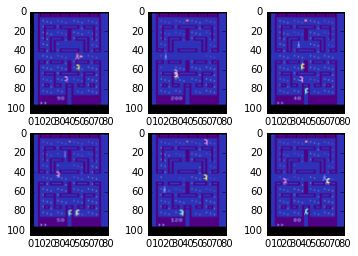

!
iter=910	epsilon=0.231	reward/step=0.16641
iter=920	epsilon=0.229	reward/step=0.16569
!
iter=930	epsilon=0.228	reward/step=0.16541
iter=940	epsilon=0.226	reward/step=0.16578
iter=950	epsilon=0.224	reward/step=0.16614
iter=960	epsilon=0.222	reward/step=0.16649
iter=970	epsilon=0.221	reward/step=0.16643
iter=980	epsilon=0.219	reward/step=0.16555
!
iter=990	epsilon=0.217	reward/step=0.16509


[2016-10-19 02:34:18,031] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 02:34:18,032] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.216	reward/step=0.16620


[2016-10-19 02:34:27,599] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1402 timesteps with reward=250.0


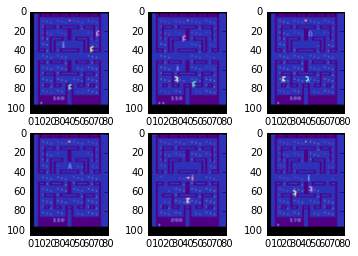

iter=1010	epsilon=0.214	reward/step=0.16420
iter=1020	epsilon=0.212	reward/step=0.16120
!
iter=1030	epsilon=0.211	reward/step=0.16080
iter=1040	epsilon=0.209	reward/step=0.15980
iter=1050	epsilon=0.207	reward/step=0.16040
iter=1060	epsilon=0.206	reward/step=0.16040
!
iter=1070	epsilon=0.204	reward/step=0.16120
!
iter=1080	epsilon=0.203	reward/step=0.16100
iter=1090	epsilon=0.201	reward/step=0.16300
!


[2016-10-19 02:56:15,287] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 02:56:15,287] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.200	reward/step=0.16400


[2016-10-19 02:56:25,469] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1584 timesteps with reward=330.0


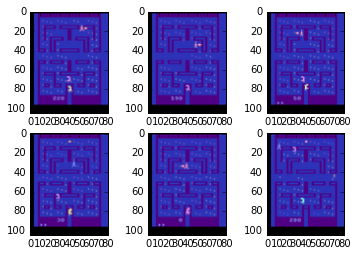

iter=1110	epsilon=0.198	reward/step=0.16540
!
iter=1120	epsilon=0.197	reward/step=0.16540
iter=1130	epsilon=0.195	reward/step=0.16560
iter=1140	epsilon=0.194	reward/step=0.17640
!
iter=1150	epsilon=0.192	reward/step=0.17780
!
iter=1160	epsilon=0.191	reward/step=0.18020
iter=1170	epsilon=0.190	reward/step=0.18160
!
iter=1180	epsilon=0.188	reward/step=0.18100
iter=1190	epsilon=0.187	reward/step=0.18280


[2016-10-19 03:17:46,504] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 03:17:46,505] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.186	reward/step=0.18460


[2016-10-19 03:17:53,360] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1072 timesteps with reward=200.0


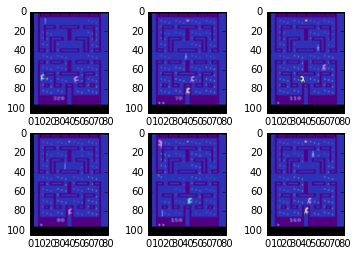

!
iter=1210	epsilon=0.184	reward/step=0.18380
iter=1220	epsilon=0.183	reward/step=0.18540
!
iter=1230	epsilon=0.182	reward/step=0.18400
iter=1240	epsilon=0.180	reward/step=0.18320
iter=1250	epsilon=0.179	reward/step=0.18360
iter=1260	epsilon=0.178	reward/step=0.18460
iter=1270	epsilon=0.176	reward/step=0.18460
iter=1280	epsilon=0.175	reward/step=0.18460
iter=1290	epsilon=0.174	reward/step=0.18460


[2016-10-19 03:39:16,535] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 03:39:16,536] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.173	reward/step=0.18480


[2016-10-19 03:39:27,234] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1639 timesteps with reward=270.0


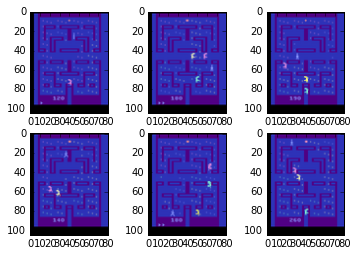

iter=1310	epsilon=0.171	reward/step=0.18280
iter=1320	epsilon=0.170	reward/step=0.18320
!
!
iter=1330	epsilon=0.169	reward/step=0.18340
!
iter=1340	epsilon=0.168	reward/step=0.18420
iter=1350	epsilon=0.167	reward/step=0.18500
!
iter=1360	epsilon=0.165	reward/step=0.18780
iter=1370	epsilon=0.164	reward/step=0.18960
iter=1380	epsilon=0.163	reward/step=0.18900
iter=1390	epsilon=0.162	reward/step=0.18880


[2016-10-19 04:01:08,061] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 04:01:08,062] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.161	reward/step=0.19040


[2016-10-19 04:01:17,040] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1263 timesteps with reward=300.0


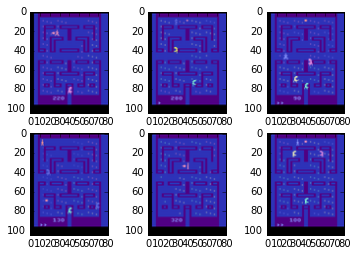

iter=1410	epsilon=0.160	reward/step=0.19120
!
iter=1420	epsilon=0.159	reward/step=0.19120
iter=1430	epsilon=0.158	reward/step=0.20120
iter=1440	epsilon=0.157	reward/step=0.20120
!
iter=1450	epsilon=0.156	reward/step=0.20220
!
iter=1460	epsilon=0.155	reward/step=0.20220
!
iter=1470	epsilon=0.153	reward/step=0.20360
!
iter=1480	epsilon=0.152	reward/step=0.20540
iter=1490	epsilon=0.151	reward/step=0.20740


[2016-10-19 04:23:15,404] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 04:23:15,405] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.150	reward/step=0.20640


[2016-10-19 04:23:22,538] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1051 timesteps with reward=250.0


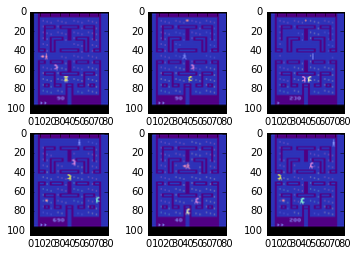

iter=1510	epsilon=0.149	reward/step=0.20460
iter=1520	epsilon=0.148	reward/step=0.20500
iter=1530	epsilon=0.147	reward/step=0.20440
!
iter=1540	epsilon=0.146	reward/step=0.20640
iter=1550	epsilon=0.146	reward/step=0.20820
iter=1560	epsilon=0.145	reward/step=0.20860
iter=1570	epsilon=0.144	reward/step=0.20800
iter=1580	epsilon=0.143	reward/step=0.20640
iter=1590	epsilon=0.142	reward/step=0.20560
!


[2016-10-19 04:45:16,072] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 04:45:16,072] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.141	reward/step=0.20540


[2016-10-19 04:45:28,211] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1863 timesteps with reward=890.0


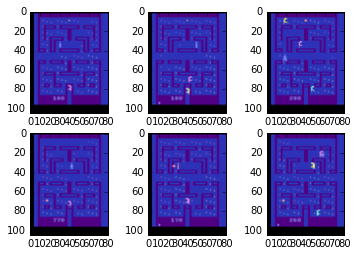

iter=1610	epsilon=0.140	reward/step=0.20600
iter=1620	epsilon=0.139	reward/step=0.20580
!
!
iter=1630	epsilon=0.138	reward/step=0.20660
iter=1640	epsilon=0.137	reward/step=0.20620
!
iter=1650	epsilon=0.136	reward/step=0.20540


KeyboardInterrupt: 

In [22]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**10):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(5):
        loss = train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        

    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

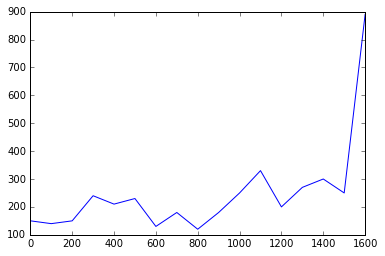

In [23]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [26]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%rw)

[2016-10-19 05:01:32,554] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 05:01:32,555] Clearing 1 monitor files from previous run (because force=True was provided)


Episode finished after 1030 timesteps with reward=250.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1175 timesteps with reward=270.0
!
Episode finished after 1103 timesteps with reward=290.0
!
Episode finished after 1325 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1125 timesteps with reward=230.0
!
Episode finished after 1322 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1340 timesteps with reward=320.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finished after 1204 timesteps with reward=300.0
!
Episode finished after 1340 timesteps with reward=280.0
!
Episode finish

[2016-10-19 05:04:18,972] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/yozhik/dive_to_dqn/records')


Episode finished after 1340 timesteps with reward=280.0
mean session score=279.000000.5


In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__